In [63]:
import pyfair

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os

In [64]:
from pyfair.report.individual import FairReport

In [72]:
model1 = pyfair.FairModel(name="HA", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model1.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model1.calculate_all()


#fr = FairReport(model1)
#fr.to_html('C:/Users/theon/Desktop/report.html')
results = model1.export_results()
node_statuses = model1.get_node_statuses()

In [79]:
results.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Risk,3.76056e+06,2.73606e+06,1.28062e+06,2.83429e+06,2.86241e+06,7.30559e+06,1.84324e+06,5.43455e+06,1.28197e+06,2.31382e+06,...,154061,1.9235e+06,2.63536e+06,2.5058e+06,3.13091e+06,6.23696e+06,875201,115222,3.48468e+06,1.21616e+06
Loss Event Frequency,0.0826655,0.284836,0.109503,0.245684,0.0614085,0.348857,0.19866,0.158152,0.141395,0.196031,...,0.252786,0.262203,0.153701,0.260049,0.251511,0.326513,0.298684,0.247165,0.338601,0.287906
Threat Event Frequency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vulnerability,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Threat Capability,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Control Strength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Probable Loss Magnitude,3.76056e+06,2.73606e+06,1.28062e+06,2.83429e+06,2.86241e+06,7.30559e+06,1.84324e+06,5.43455e+06,1.28197e+06,2.31382e+06,...,154061,1.9235e+06,2.63536e+06,2.5058e+06,3.13091e+06,6.23696e+06,875201,115222,3.48468e+06,1.21616e+06
Primary Loss Factors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
statuses = model1.get_node_statuses()
colors = pd.DataFrame.from_records([statuses]).T
colors = colors.sort_index()
colors.columns = ['status']
#colors['color'] = colors['status'].map({'Not Required': 'grey', 'Supplied': 'green', 'Calculated': 'blue'})
colors

# Drop everything not in index
ftg._data

,status,color,tag,self_x,self_y,parent_x,parent_y,μ,σ,high,low,mode
Action,Not Required,grey,A,1200,0,600,800,NaN,NaN,NaN,NaN,NaN
Asset Loss Factors,Not Required,grey,ALF,4800,0,5400,800,NaN,NaN,NaN,NaN,NaN
Contact,Not Required,grey,C,0,0,600,800,NaN,NaN,NaN,NaN,NaN
Control Strength,Not Required,grey,CS,3600,0,3000,800,NaN,NaN,NaN,NaN,NaN
External Loss Factors,Not Required,grey,ELF,8400,0,7800,800,NaN,NaN,NaN,NaN,NaN
Loss Event Frequency,Supplied,green,LEF,1800,1600,4200,2400,2.174925e-01,8.113345e-02,0.5,0.01,0.2
Organizational Loss Factors,Not Required,grey,OLF,7200,0,7800,800,NaN,NaN,NaN,NaN,NaN
Primary Loss Factors,Not Required,grey,PLF,5400,800,6600,1600,NaN,NaN,NaN,NaN,NaN
Probable Loss Magnitude,Supplied,green,PLM,6600,1600,4200,2400,2.331760e+06,1.675184e+06,10000000,1,1000000
Risk,Calculated,blue,R,4200,2400,4200,5000,2.331761e+06,1.675184e+06,NaN,NaN,NaN


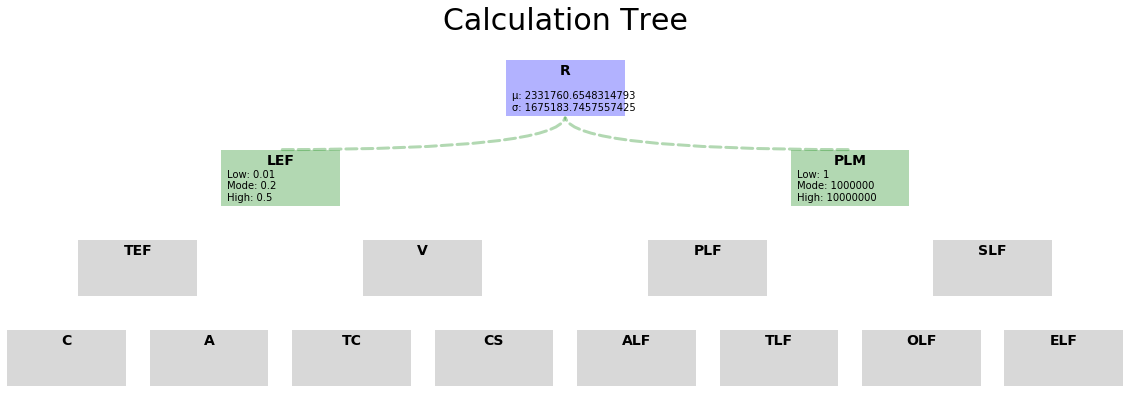

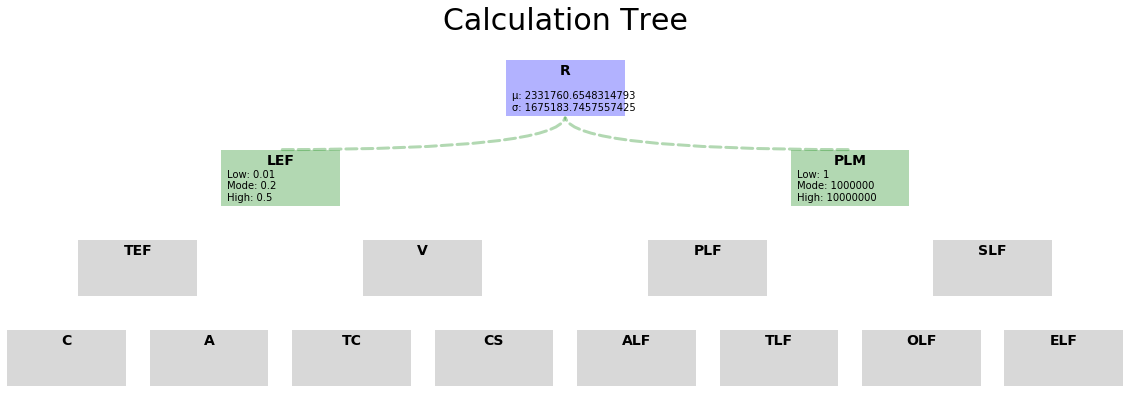

In [130]:
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


class FairTreeGraph(object):
    '''Provides a pretty tree diagram to summarize calculations.'''
    
    # Class attribute
    DIMENSIONS = pd.DataFrame.from_dict({
    'Contact'                    : ['C'  ,    0,    0,  600,  800],
    'Threat Event Frequency'     : ['TEF',  600,  800, 1800, 1600],
    'Action'                     : ['A'  , 1200,    0,  600,  800],
    'Threat Capability'          : ['TC' , 2400,    0, 3000,  800],
    'Vulnerability'              : ['V'  , 3000,  800, 1800, 1600],
    'Control Strength'           : ['CS' , 3600,    0, 3000,  800],
    'Probable Loss Magnitude'    : ['PLM', 6600, 1600, 4200, 2400],
    'Loss Event Frequency'       : ['LEF', 1800, 1600, 4200, 2400],
    'Risk'                       : ['R'  , 4200, 2400, 4200, 5000],
    'Primary Loss Factors'       : ['PLF', 5400,  800, 6600, 1600],
    'Secondary Loss Factors'     : ['SLF', 7800,  800, 6600, 1600],
    'Asset Loss Factors'         : ['ALF', 4800,    0, 5400,  800],
    'Threat Loss Factors'        : ['TLF', 6000,    0, 5400,  800],
    'Organizational Loss Factors': ['OLF', 7200,    0, 7800,  800],
    'External Loss Factors'      : ['ELF', 8400,    0, 7800,  800],
}, orient='index', columns=['tag', 'self_x', 'self_y', 'parent_x', 'parent_y'])
    
    def __init__(self, results, statuses, params):
        self._colormap = {'Not Required': 'grey', 'Supplied': 'green', 'Calculated': 'blue'}
        self._results = results.T
        self._result_summary = pd.DataFrame({'μ': results.T.mean(axis=1), 'σ': results.T.std(axis=1)})
        # Make status input into a dataframe.
        self._statuses = statuses
        self._process_statuses()
        self._params = pd.DataFrame(params).T.reindex(self._statuses.index)
        self._data = pd.concat([
            self._statuses, 
            self.DIMENSIONS, 
            self._result_summary,
            self._params
        ], axis=1, sort=True)

    def _process_statuses(self):
        '''Turn dict into df and add color column'''
        self._statuses = pd.DataFrame.from_records([statuses]).T
        self._statuses.columns = ['status']
        self._statuses['color'] = self._statuses['status'].map(self._colormap)
        
    def _tweak_axes(self, ax):
        # Set title
        ax.set_title('Calculation Tree', fontsize=30, pad=30)
        # Set limits
        ax.set_xlim(0, 9_400)
        ax.set_ylim(0, 2_900)
        # Disappear axes and spines
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_visible(False)
        for spine_name in ['left', 'right', 'top', 'bottom']:
            ax.spines[spine_name].set_visible(False)
        return ax
    
    def _generate_rects(self, ax):
        '''Cannot be done via apply'''
        patches = []
        patch_colors = []
        for index, row in self._data.iterrows():
            rect = Rectangle(
                (row['self_x'], row['self_y']),
                1000,
                500,
                alpha=.3,
            )
            patches.append(rect)
            patch_colors.append(row['color'])
        collection = PatchCollection(patches, facecolor=patch_colors, alpha=.3)
        ax.add_collection(collection)
        return ax
    
    def _generate_text(self, row, ax):
        '''Apply-able function'''
        # Draw header
        plt.text(
            row['self_x'] + 500, 
            row['self_y'] + 370, 
            row['tag'], 
            horizontalalignment='center',
            fontsize=14,
            fontweight='bold',
        )
        # Draw data
        if row['status'] == 'Calculated':
            output = 'μ: ' + str(row['μ']) +  '\n' + 'σ: ' + str(row['σ'])
        elif row['status'] == 'Supplied' and row.name != 'Vulnerability':
            output = 'Low: ' +  str(row['low']) + '\nMode: ' + str(row['mode']) + '\nHigh: ' + str(row['high'])
        elif row['status'] == 'Supplied' and row.name == 'Vulnerability':
            output = ''
        else:
            output = ''
        plt.text(
            row['self_x'] + 50, 
            row['self_y'] + 50, 
            output, 
            horizontalalignment='left',
            fontsize=10,
        )

    def _generate_lines(self, row, ax):
        if (row['color'] != 'grey') and row.name != 'Risk':
            ax.annotate(
                None,
                xy=(row['parent_x'] + 500, row['parent_y']), 
                xytext=(row['self_x'] + 500, row['self_y'] + 500),     
                arrowprops=dict(
                    arrowstyle="-",
                    connectionstyle="angle3,angleA=0,angleB=-90",
                    ec=row['color'],
                    alpha=.3,
                    linestyle='--', 
                    linewidth=3
                ),
            )
        
    def generate_image(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(20,6)
        ax = self._tweak_axes(ax)
        self._data.apply(self._generate_text, args=[ax], axis=1)
        self._generate_rects(ax)
        self._data.apply(self._generate_lines, args=[ax], axis=1)
        return fig
    
    
# Test
ftg = FairTreeGraph(
    results=model1.export_results(),
    statuses=model1.get_node_statuses(),
    params=model1.export_params()
)

ftg.generate_image()

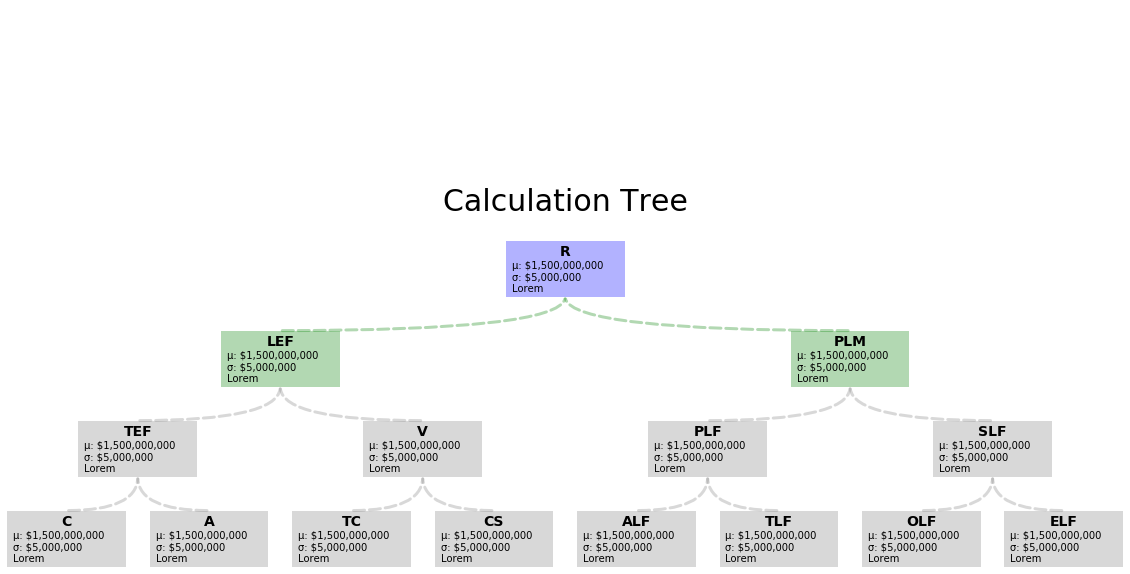

In [62]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
fig.set_size_inches(20,6)
ax.set_xlim(0, 9_400)
ax.set_ylim(0, 2_900)

dimensions = pd.DataFrame.from_dict({
    'Contact'                    : ['C'  ,    0,    0,  600,  800],
    'Threat Event Frequency'     : ['TEF',  600,  800, 1800, 1600],
    'Action'                     : ['A'  , 1200,    0,  600,  800],
    'Threat Capability'          : ['TC' , 2400,    0, 3000,  800],
    'Vulnerability'              : ['V'  , 3000,  800, 1800, 1600],
    'Control Strength'           : ['CS' , 3600,    0, 3000,  800],
    'Probable Loss Magnitude'    : ['PLM', 6600, 1600, 4200, 2400],
    'Loss Event Frequency'       : ['LEF', 1800, 1600, 4200, 2400],
    'Risk'                       : ['R'  , 4200, 2400, 4200, 5000],
    'Primary Loss Factors'       : ['PLF', 5400,  800, 6600, 1600],
    'Secondary Loss Factors'     : ['SLF', 7800,  800, 6600, 1600],
    'Asset Loss Factors'         : ['ALF', 4800,    0, 5400,  800],
    'Threat Loss Factors'        : ['TLF', 6000,    0, 5400,  800],
    'Organizational Loss Factors': ['OLF', 7200,    0, 7800,  800],
    'External Loss Factors'      : ['ELF', 8400,    0, 7800,  800],
}, orient='index', columns=['tag', 'self_x', 'self_y', 'parent_x', 'parent_y'])


combined = pd.concat([colors, dimensions], axis=1, sort=True)

patches = []
patch_colors = []

def draw_node(row, ax, patches):
    rect = Rectangle(
        (row['self_x'], row['self_y']),
        1000,
        500,
        alpha=.3,
    )
    # Title
    plt.text(
        row['self_x'] + 500, 
        row['self_y'] + 370, 
        row['tag'], 
        horizontalalignment='center',
        fontsize=14,
        fontweight='bold',
    )
    # Other
    plt.text(
        row['self_x'] + 50, 
        row['self_y'] + 50, 
        'μ: $1,500,000,000\nσ: $5,000,000\nLorem', 
        horizontalalignment='left',
        fontsize=10,
    )
    patches.append(rect)
    patch_colors.append(row['color'])
    if (row['color'] != 'grey') or row.name != 'Risk':
        ax.annotate(
            None,
            xy=(row['parent_x'] + 500, row['parent_y']), 
            xytext=(row['self_x'] + 500, row['self_y'] + 500),     
            arrowprops=dict(
                arrowstyle="-",
                connectionstyle="angle3,angleA=0,angleB=-90",
                ec=row['color'],
                alpha=.3,
                linestyle='--', 
                linewidth=3
            ),
        )

#combined = combined.dropna(axis=0)
combined.apply(draw_node, axis=1, args=[ax, patches])

collection = PatchCollection(patches, facecolor=patch_colors, alpha=.3)
ax.add_collection(collection)

ax.set_title('Calculation Tree', fontsize=30, pad=30)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for spine_name in ['left', 'right', 'top', 'bottom']:
    ax.spines[spine_name].set_visible(False)


dimensions

fig.savefig('test_fig.png')

In [3]:
model1 = pyfair.FairModel(name="HA", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model1.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model1.calculate_all()

model2 = pyfair.FairModel(name="NOT HA", n_simulations=10_000)
model2.input_data('Loss Event Frequency', low=.01, mode=.2, high=.5)
model2.input_data('Probable Loss Magnitude', low=1, mode=1_000_000, high=10_000_000)
model2.calculate_all()


meta1 = pyfair.FairMetaModel('Metamodel', [model1, model2])
out_json = pyfair.FairMetaModel('Metamodel2', [model1, meta1])

In [4]:
str(type(meta1))

"<class 'pyfair.model.meta_model.FairMetaModel'>"

In [ ]:
'''
FairModel
    Just one
FairAddititveMetaModel
    Add all the risks together and display with components
FairComparativeMetaModel
    Put risks side by side
    
Mu, Sigma for Risk

Model Params

Source
'''

In [7]:
metadata = pd.Series(
    {
        'Author': os.environ['USERNAME'],
        'Generated': str(pd.datetime.now()).partition('.')[0],
        'PyFair Version': pyfair.VERSION
    }
).to_frame()

metadata

,0
Author,theon
Generated,2019-05-13 08:25:21
PyFair Version,0.0.1


In [ ]:
#### Left third, provided data. RIght 2/3rds, tree
model2 = pyfair.read_json(results)
params = model2.export_params()
data = model2.export_results()
del params['Creation Datetime']
df = pd.DataFrame.from_dict(params)
df = df.reindex(['low', 'mode', 'high', 'p'])
df.index = df.index.str.title()
df

In [ ]:
derived = df.agg([np.mean, np.std, np.min, np.max])
derived.index = ['μ', 'σ', 'Minimum', 'Maximum']

final_data = pd.concat([derived, df], axis=0)
final_data = final_data.dropna()

# If Column as data greater than 1,
condition = final_data.max() > 1

# Get True Clumns
true_col = condition.loc[condition].index.values

#Get False COlumns
false_col = condition.loc[~condition].index.values

# If false, it's between 0 and 1. 3 decimals
final_data[false_col] = final_data[false_col]
final_data[false_col] = final_data[false_col].applymap(lambda x: '{0:.3f}'.format(x))

# If true, get the max digits and round
final_data[true_col] = final_data[true_col].astype(int)
final_data[true_col] = final_data[true_col].applymap(lambda x: '{0:,}'.format(x))

for column in ['Probable Loss Magnitude', 'Risk']:
    if column in final_data.columns:
        final_data[column] = '$' + final_data[column]

final_data.T

In [ ]:
model3 = pyfair.read_json(results)
df3 = model3.export_results()
risk = df3['Risk']
risk_d = risk.agg([np.mean, np.std, np.min, np.max]).astype(int)
risk_d.index = ['μ', 'σ', 'Minimum', 'Maximum']

pd.DataFrame(risk_d).T.applymap(lambda x: '${0:,}'.format(x))

In [ ]:
# Draw curves?
model3.__class__

In [ ]:
dollar_format_string     = '${0:,}'
integer_format_string    = '{0:,}'
percentage_format_string = '{0:.3f}'
format_strings = {
    'Risk'                        : dollar_format_string,
    'Loss Event Frequency'        : integer_format_string,
    'Threat Event Frequency'      : integer_format_string,
    'Vulnerability'               : integer_format_string,         
    'Contact'                     : percentage_format_string,
    'Action'                      : percentage_format_string,
    'Threat Capability'           : percentage_format_string,
    'Control Strength'            : percentage_format_string,
    'Probable Loss Magnitude'     : dollar_format_string,
    'Primary Loss Factors'        : dollar_format_string,
    'Asset Loss Factors'          : dollar_format_string,
    'Threat Loss Factors'         : dollar_format_string,
    'Secondary Loss Factors'      : dollar_format_string,
    'Organizational Loss Factors' : dollar_format_string,
    'External Loss Factors'       : dollar_format_string,
}

SINGLE
    header
    meta
    left third, risk top then params. right 2/3, tree diagram
    left have loss excedence, right half exceedence probability
    code
    
COMPARISON
    header
    meta
    left third, risk top then params for each. right 2/3, tree diagram
    left have loss excedence, right half exceedence probability
    code

ADDITIVE
    header
    meta
    for each:
        left third, risk top then params. right 2/3, tree diagram
        left have loss excedence, right half exceedence probability
    for all:
        loss exceedence and exceedence probability and 
        risk
    code

In [ ]:
class FairBasic()

In [ ]:
uuid.uuid1()

In [ ]:
import os
import subprocess
import tempfile

td = tempfile.mkdtemp()
tf = tempfile.NamedTemporaryFile(dir=td, mode='w+')
os.chdir(td)

tf.write('LATEX!')

os.listdir(td)

p = subprocess.run(['dir', str(td)])

In [ ]:
model

In [ ]:
td